# Outline
This tutorial demonstrates how to build, train, and evaluate a Convolutional Neural Network (CNN) classifier for astronomical image data using PyTorch.

- `Dataset`: Galaxy MNIST — images of galaxies with different morphologies, observed in three optical bands
- `CNN Models`: ResNet and a custom architecture
- `Objective`: Classify input images into one of four classes

The tutorial will guide you through the following steps:

1) Setting up the environment
2) Downloading the dataset and preparing data loaders with appropriate transformations and augmentations
3) Building a CNN classifier using a predefined architecture (ResNet)
4) Training the model
5) Evaluating the model on the test dataset
6) Building a configurable CNN with a custom architecture, encouraging users to implement the training and evaluation steps based on the ResNet example

# Configuring the environment

## Module installation
We’ll begin by installing the necessary Python modules for this tutorial.

In [ ]:
import os

# - Install modules from requirements.txt if present
if os.path.isfile("requirements.txt"):
  print("Installing modules from local requirements.txt file ...")
  %pip install -q -r requirements.txt
else:
  print("Installing modules ...")

  %pip install -q pillow opencv-python                                 # Img processing modules
  %pip install -q torch torchvision torchmetrics torchsummary grad-cam umap-learn[plot] # ML modules
  %pip install -q gdown matplotlib tqdm                                # Plot/util modules

  # - Create requirements file
  %pip freeze > requirements.txt

## Import modules
Next, we import the essential modules needed throughout the tutorial.

In [ ]:
###########################
##   STANDARD MODULES
###########################
import os
from pathlib import Path
import shutil
import gdown
import tarfile
import numpy as np
import json
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from itertools import islice
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

###########################
##   IMGPROC/TORCH MODULES
###########################
# - Image proc
import PIL
from PIL import Image
import cv2
from sklearn.preprocessing import StandardScaler

# - Torch modules
import torch
from torch import Tensor
from torch.utils.data import Dataset, Subset, random_split
import torchvision
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
import torchmetrics
from torchsummary import summary

# - UMAP
import umap, umap.plot

# - GradCAM
from pytorch_grad_cam import (
  GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
  AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
  LayerCAM, FullGrad, GradCAMElementWise, KPCA_CAM
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
from pytorch_grad_cam.utils.image import show_cam_on_image

## Set random seeds
Let's define a function to set random numpy/torch seeds to make random generation reproducible.

In [ ]:
def set_seed(seed=42):
  """ Set random seed """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

  torch.cuda.manual_seed_all(seed) # should be safe even if CUDA not available
  torch.backends.cudnn.deterministic= True
  torch.backends.cudnn.benchmark= False

# - Set the seed
set_seed(1)

## Project folders
We create a working directory `rundir` to run the tutorial in.

In [ ]:
topdir= os.getcwd()
rundir= os.path.join(topdir, "run-gmnist_classifier")
path = Path(rundir)
path.mkdir(parents=True, exist_ok=True)

# Dataset
For this tutorial, we will use the [**Galaxy MNIST dataset**](https://github.com/mwalmsley/galaxy_mnist).

This dataset contains **10,000 images** of galaxies observed in three optical bands (*g*, *r*, and *z*), available at two resolutions:

- **Low resolution**: `64×64×3`  
- **High resolution**: `224×224×3`  

The images are sourced from the **Dark Energy Camera Legacy Survey (DECaLS)** as part of the **Galaxy Zoo** project. DECaLS observations were conducted using the **Dark Energy Camera (DECam)** mounted on the 4-meter Blanco Telescope in Chile. Fluxes in the *grz* bands were converted to RGB colors (see Section 2.3 of the reference paper), and each galaxy image was saved in PNG format.

The dataset is divided into two subsets:

- **Training set**: 8,000 images  
- **Test set**: 2,000 images  

Each image is labeled as one of the following four classes:

1. **SMOOTH_ROUND**  
   Smooth, round galaxies without visible spiral features

2. **SMOOTH_CIGAR**  
   Smooth, elongated (cigar-shaped) galaxies, typically seen edge-on, without signs of spiral structure

3. **EDGE_ON_DISK**  
   Disk or spiral galaxies seen edge-on, often with visible spiral arms or structural irregularities

4. **UNBARRED_SPIRAL**  
   Face-on, unbarred spiral galaxies with visible disk and/or spiral arms
   
Examples of each class are shown in the image below.

<img src="https://github.com/simoneriggi/usc8-ai-workshop/blob/main/media/gmnist.png?raw=1" style="display: block; margin-left: 0; width: 400px;" />

> **Note**:  
> The classes **SMOOTH_CIGAR** and **EDGE_ON_DISK** can appear very similar.  
> - If the galaxy appears smooth and uniform, possibly with a small central bulge, it likely belongs to **SMOOTH_CIGAR**.  
> - If the galaxy shows structural features or irregularities, it is more likely an **EDGE_ON_DISK** galaxy.

In this tutorial, we will use the **high-resolution images** (`224×224` pixels).  
The dataset has been **slightly modified** from its original format and is available for download from **Google Drive**.

More details on the observational data and labelling are available in these references:

- [Galaxy Zoo DECaLS paper](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.3966W/abstract)    
- [Galaxy Zoo DECaLS data](https://zenodo.org/records/4573248)

## Dataset Download
Next, we download the dataset from Google Drive and unzip it in the main folder.

In [ ]:
# - Set dataset URL & paths
dataset_name= "galaxy_mnist-dataset"
dataset_dir= os.path.join(rundir, dataset_name)
dataset_tar= 'galaxy_mnist-dataset.tar.gz'
dataset_tar_fullpath= os.path.join(rundir, dataset_tar)
dataset_url= 'https://drive.google.com/uc?export=download&id=1OprJ_NQIFyQSRWqjGLFQsAMumHvJ-tMB'

# - Download dataset (if not previously downloaded)
if not os.path.isfile(dataset_tar_fullpath):
  print("Downloading file from url %s ..." % (dataset_url))
  gdown.download(dataset_url, dataset_tar, quiet=False)
  print("DONE!")

# - Untar dataset
if not os.path.isdir(dataset_dir):
  print("Unzipping dataset file %s ..." % (dataset_tar))
  fp= tarfile.open(dataset_tar)
  fp.extractall('.')
  fp.close()
  print("DONE!")

# - Moving data to rundir
if not os.path.isfile(dataset_tar_fullpath):
  print("Moving tar file to rundir %s ..." % (rundir))
  shutil.move(dataset_tar, rundir)

if not os.path.isdir(dataset_dir):
  print("Moving datadir to rundir %s ..." % (rundir))
  shutil.move(dataset_name, rundir)

The dataset includes data lists for both training and test samples, provided in JSON format. These lists are available for both 1-channel (channel-averaged) and 3-channel (RGB) image data.

In this tutorial, we will use the 3-channel image data:

- `train/3chan/datalist_train.json`
- `test/3chan/datalist_test.json`

Each data list follows the structure below:

```json
{    
  "data": [    
    {    
      "filepaths": [
        "galaxy_mnist-dataset/train/3chan/train_1.png"
      ],
      "sname": "S1",
      "id": 1,
      "label": "smooth_cigar"
    },    
    ...
    ...
  ]
}
```

- `filepaths`: A list of one or more image file paths. In this case only 1 image is available per source.
- `sname`: A short source name identifier
- `label`/`id`: The ground-truth galaxy class label and target:      

      0: "smooth_round"  
      1: "smooth_cigar"   
      2: "edge_on_disk"    
      3: "unbarred_spiral"      

## Create PyTorch Dataset
We define a custom PyTorch dataset for the Galaxy MNIST data by subclassing the `torch.utils.data.Dataset` base class. To do this, we need to override the following essential methods:

`__len__`: Returns the total number of samples in the dataset.   
`__getitem__`: Returns the i-th sample, including the image and its corresponding target label.   

The custom dataset class accepts the following arguments:

- `metadata_file`: Path to the JSON file containing the data list;
- `subset`: An instance of `torch.utils.data.Subset` to create a subset of the original dataset;
- `transform`: A `torchvision.transforms` object for applying transformations to the input images;
- `data_path`: Path to the root dataset directory (e.g., your `rundir`).

You must provide the `metadata_file` or, alternatively, the `subset`.

In [ ]:
class GMNISTDataset(Dataset):
  """ Galaxy MNIST dataset """

  def __init__(
      self,
      metadata_file: Optional[Union[str, Path]] = "",
      subset: Optional[Subset] = None,
      transform: Optional[Callable] = None,
      data_path: Optional[Union[str, Path]] = "",
  ):

    # - Check args
    if not os.path.isfile(metadata_file) and subset is None:
      raise("You must provide metadata_file or subset!")

    if data_path!="" and not os.path.isdir(data_path):
      raise("Invalid data_path given, it must be an existing path!")

    # - Read metadata
    self.subset= subset
    if self.subset is None:
      print(f"Reading dataset metadata from file {metadata_file}...")
      self.__read_metadata(metadata_file)

    # - Set pars
    self.data_path= data_path
    self.transform = transform
    self.pil2tensor = T.Compose([T.PILToTensor()])

    self.target2label= {
      0: "smooth_round",
      1: "smooth_cigar",
      2: "edge_on_disk",
      3: "unbarred_spiral"
    }

  def __read_metadata(self, filename: Union[str, Path]) -> None:
    """ Read JSON metadata """

    with open(filename, "r") as f:
      self.datalist= json.load(f)["data"]

  def __len__(self) -> int:
    """ Return the size of the dataset """
    return len(self.subset) if self.subset else len(self.datalist)

  def __load_item(self, idx: int):
    """ Load an individual sample """

    # - Read image path & class id
    item = self.datalist[idx]
    target= item['id']
    img_path= item['filepaths'][0]
    if self.data_path!="":
      img_path= os.path.join(self.data_path, img_path)

    # - Read PIL image as RGB
    img = Image.open(img_path).convert("RGB")

    return img, target

  def __getitem__(self, idx: int):
    """Return a dataset sample (image, target)."""

    # - Load image & target
    img, target = self.subset[idx] if self.subset else self.__load_item(idx)

    # - Convert PIL image to tensor if needed
    if isinstance(img, PIL.Image.Image):
      img = self.pil2tensor(img)

    # - Replace NaN or Inf with zeros
    img[~torch.isfinite(img)] = 0

    # - Apply transforms
    if self.transform:
      img = self.transform(img)

    return img, target

## Create data custom transforms
We define a set of custom image transformations to be used as data augmentations. To implement a custom transformation in PyTorch, simply subclass `nn.Module` and override the `forward` method, as shown in the examples below.

This allows seamless integration with `torchvision.transforms.Compose` and keeps transformations modular and reusable.

### Random flip
A transformation that randomly flips the image either horizontally, vertically, or leaves it unchanged.

In [ ]:
class RandomFlip(torch.nn.Module):
  """ Randomly flip the image horizontally, vertically, or leave it unchanged. """

  def __init__(self):
    super().__init__()

  def forward(self, img: Union[Image.Image, Tensor]) -> Union[Image.Image, Tensor]:
    op = random.choice(["hflip", "vflip", "none"])
    if op == "hflip":
      return TF.hflip(img)
    elif op == "vflip":
      return TF.vflip(img)
    else:
      return img

### Random rotate
A transform that randomly rotate image by either 90, 180, 270 degrees or leave image unchanged.

In [ ]:
class RandomRotate90(torch.nn.Module):
  """ Randomly rotate the image by 90°, 180°, 270°, or leave it unchanged. """

  def __init__(self):
    super().__init__()

  def forward(self, img: Union[Image.Image, Tensor]) -> Union[Image.Image, Tensor]:
    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
      return TF.rotate(img, angle)
    return img

### Absolute Channel Maximum Scaling
This transform finds, for each image, the absolute maximum, and then it scales all channels by this value, taking into account any possible band flux ratio information as sensitive classification variable.

In [ ]:
class AbsChanMaxScaling(torch.nn.Module):
  """ Scales an image tensor by the absolute maximum across all channels."""

  def __init__(self):
    super().__init__()

  def forward(self, img: Tensor) -> Tensor:

    # - Compute absolute image max across channels
    if img.ndim == 4:  # [B, C, H, W]
      abs_max = torch.amax(img, dim=(1, 2, 3), keepdim=True)
    elif img.ndim == 3:  # [C, H, W]
      abs_max = torch.amax(img, dim=(0, 1, 2), keepdim=True)
    else:
      warnings.warn(f"Unexpected tensor dimension ({img.ndim}). Returning input unmodified.")
      return img

    # - Scale image by absmax, avoiding division by zero
    abs_max = abs_max.clamp(min=1e-8)
    return img / abs_max

### My custom transform
Think about other augmentations you could experiment with to improve model performance!

In [ ]:
## DEFINE YOUR OWN TRANSFORM HERE!
# ...
# ...

### Define composite transforms
We will define two composite transforms:

- Training transform: includes both standard preprocessing and additional augmentation transforms
- Validation/Test transform: includes only the standard preprocessing steps (no augmentation)

**Standard Transforms**    
These are applied to all data (train and test):

- Image resize
- Absolute channel max scaling

**Augmentation Transforms**    
These are applied only to the training data:

- Random flipping
- Random 90-degree rotation
- Random crop and resize

You may also consider whether it's beneficial to include the following normalization step, which is commonly used for ImageNet-pretrained models:

``` python
T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
```

> ⚠️ **Note:** While this normalization is standard for natural images, it may not be optimal for astronomical data. Use with care depending on your goals (e.g., fine-tuning a pretrained model vs. training from scratch).

In [ ]:
# - Define image resize size
img_resize= 224

# - Define transforms for train data
transform_train= T.Compose(
  [
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    RandomFlip(),
    RandomRotate90(),
    T.RandomResizedCrop(
      img_resize,
      scale=(0.5, 1.0),
      ratio=(1., 1.),
      interpolation=T.InterpolationMode.BICUBIC
    ),
    AbsChanMaxScaling(),

    # Optional: Normalize using ImageNet statistics
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ]
)

# - Define transforms for val/test data
transform_eval= T.Compose(
  [
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling(),

    # Optional: Normalize using ImageNet statistics
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ]
)

# - Define transforms for plotting purposes
transform= T.Compose(
  [
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling()
  ]
)

## Create datasets
We will load the Galaxy MNIST training and test datasets using the `GMNISTDataset` class defined earlier.
After loading the full training set, we will split it into two subsets:

- Training set: 70% of the original training data
- Validation set: 30% of the original training data

This split allows us to validate model performance during training while keeping the test set strictly for final evaluation.

In [ ]:
# - Set paths to train/test datalists
filename_train_3chan= os.path.join(dataset_dir, "train/3chan/datalist_train.json")
filename_test_3chan= os.path.join(dataset_dir, "test/3chan/datalist_test.json")

# - Load full training (train + validation) dataset
print(f"Reading train-cv dataset from: {filename_train_3chan}")
dataset_traincv= GMNISTDataset(
  metadata_file=filename_train_3chan,
  transform=transform,
  data_path=rundir
)

# - Load test dataset
print(f"Reading test dataset from: {filename_test_3chan}")
dataset_test= GMNISTDataset(
  metadata_file=filename_test_3chan,
  transform=transform_eval,
  data_path=rundir
)

# - Split train-cv into 70% training and 30% validation subsets
print("Splitting train-cv dataset into 70% train / 30% val subsets...")
generator= torch.Generator().manual_seed(42)
subset_train, subset_val= random_split(dataset_traincv, [0.7, 0.3], generator=generator)

# - Create training and validation datasets from subsets
print("Creating train & val datasets from subsets ...")
dataset_train= GMNISTDataset(
  subset=subset_train,
  transform=transform_train,
  data_path=rundir
)

dataset_val= GMNISTDataset(
  subset=subset_val,
  transform=transform_eval,
  data_path=rundir
)

# - We create a test dataset with minimal transforms for plot purposes
dataset_test_draw= GMNISTDataset(
  metadata_file=filename_test_3chan,
  transform=transform,
  data_path=rundir
)

# - Print dataset sizes
print(f"# {len(dataset_train)} samples in training set")
print(f"# {len(dataset_val)} samples in validation set")
print(f"# {len(dataset_test)} samples in test set")

### Draw sample images
Let's draw some sample images from the train set.

In [ ]:
# - Create figure
fig = plt.figure(figsize=(15, 15))

# - Show 16 sample images from the train dataset
for i, (tensor_image, target) in islice(enumerate(dataset_test_draw), 16):
  label = dataset_train.target2label[target]
  ax = fig.add_subplot(4, 4, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(tensor_image.permute(1, 2, 0))  # CHW -> HWC
  ax.set_title(label, fontsize=15)

plt.tight_layout()
plt.show()

## Create dataloaders
We will now create `DataLoader` objects for the training, validation, and test datasets.  
These loaders will efficiently batch and shuffle data during training and evaluation.

In [ ]:
##################################
##     CREATE DATALOADERS
##################################
# - Define batch size
batch_size = 64

# - Create training DataLoader
dataloader_train= torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True,
  num_workers=1
)

# - Create validation DataLoader
dataloader_val= torch.utils.data.DataLoader(
  dataset_val,
  batch_size=batch_size,
  shuffle=False,
  num_workers=1
)

# Create test DataLoader (smaller batch size for visualization/debugging)
dataloader_test= torch.utils.data.DataLoader(
  dataset_test,
  batch_size=8,
  shuffle=False,
  num_workers=1
)

##################################
##    DATA INSPECTION
##################################
# - Fetch one batch from test loader
imgs, targets = next(iter(dataloader_test))
print(f"Type of imgs: {type(imgs)}")
print(f"Shape of imgs: {imgs.shape}")

# - Compute statistics
data_min = torch.amin(imgs, dim=(2, 3))         # per-channel min for each image
data_max = torch.amax(imgs, dim=(2, 3))         # per-channel max for each image
data_absmax = torch.amax(torch.abs(imgs), dim=(1, 2, 3))  # absolute max per image

print("Per-channel min:\n", data_min)
print("Per-channel max:\n", data_max)
print("Per-image abs max:\n", data_absmax)

# CNN classifier
We will implement two different CNN classifiers to perform image classification on the Galaxy MNIST dataset:

- ResNet architecture (predefined, widely used, and powerful)
- Custom architecture (flexible and user-defined)

We will provide a complete, end-to-end example using the ResNet model.
For the custom architecture, we will offer partial implementations along with hints and guidelines, allowing you to complete the design and training as an exercise.

## ResNet classifier
We will define a classifier class for Galaxy MNIST image classification using a pretrained ResNet model.

To do this, we will leverage the predefined architectures available in `torchvision.models` and build our model pipeline using PyTorch’s `nn.Sequential` class for modularity and clarity.

This approach allows us to reuse powerful pretrained features while adapting the final classification layer to match the Galaxy MNIST label space.

In [ ]:
class ResNetClassifier():
  """ Build a ResNet classifier """

  def __init__(
    self,
    nn_arch: str = "resnet18",
    pretrained_weights: Optional[str] = None,
    num_classes: int = 4,
    n_dense_layers: int = 1,
    dense_layer_sizes: Union[int, List[int]] = 64,
    add_dropout: bool = True,
    dropout_prob: float = 0.5,
  ):
    """ Initialize class """

    self.model= None
    self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.nn_arch= nn_arch
    self.pretrained_weights= pretrained_weights
    self.num_classes= num_classes
    self.n_dense_layers= n_dense_layers
    self.add_dropout= add_dropout
    self.dropout_prob= dropout_prob

    # - Set dense layer size per layer
    if isinstance(dense_layer_sizes, list):
      if len(dense_layer_sizes) != self.n_dense_layers:
        raise ValueError("dense_layer_sizes list must match n_dense_layers!")
      self.dense_layer_sizes= dense_layer_sizes
    else:
      self.dense_layer_sizes= [dense_layer_sizes]*self.n_dense_layers

    # - Build and move model
    if self.__build_model()<0:
      raise RuntimeError("Failed to build model!")

    print(f"Moving model to device: {self.device}")
    self.model.to(self.device)

  def __build_model(self) -> int:
    """Create network from predefined ResNet architecture."""

    print(f"Building model with architecture: {self.nn_arch}")

    # - Load pretrained model
    #   NB: Supported weights for resnet18/34: 'IMAGENET1K_V1'
    #       Supported weights for resnet50/101: {'IMAGENET1K_V1','IMAGENET1K_V2'}
    try:
      self.model = getattr(torchvision.models, self.nn_arch)(weights=self.pretrained_weights)
    except AttributeError:
      print(f"ERROR: Unsupported architecture '{self.nn_arch}'.")
      print("Available models:")
      print(torchvision.models.list_models(module=torchvision.models))
      return -1

    # - Build classification head
    class_head = torch.nn.Sequential()

    for i, layer_size in enumerate(self.dense_layer_sizes):
      class_head.add_module(f"fc{i+1}", torch.nn.LazyLinear(layer_size))
      class_head.add_module(f"relu_fc{i+1}", torch.nn.ReLU())
      if self.add_dropout:
        class_head.add_module(f"dropout{i+1}", torch.nn.Dropout(p=self.dropout_prob))

    if self.n_dense_layers == 0 and self.add_dropout:
      class_head.add_module("dropout", torch.nn.Dropout(p=self.dropout_prob))

    # - Final output layer
    class_head.add_module("output", torch.nn.LazyLinear(self.num_classes))

    # - Replace ResNet classifier head
    self.model.fc = class_head

    return 0

We'll now create an instance of the ResNet classifier using the ResNet18 architecture with ImageNet pre-trained weights.

The classification head is configured as follows:

- 1 dense hidden layer with 64 neurons
- Dropout applied after the dense layer with a probability of 0.5

Feel free to modify these settings (e.g., architecture, number of layers, dropout rate) to experiment with different model configurations.

In [ ]:
# - Define model configuration
nn_arch= "resnet18"
pretrained_weights="DEFAULT"
n_dense_layers= 1
dense_layer_sizes= [64]
add_dropout= True
dropout_prob= 0.5

# - Create model instance
classifier_resnet= ResNetClassifier(
  nn_arch=nn_arch,
  pretrained_weights=pretrained_weights,
  num_classes=4,
  n_dense_layers=n_dense_layers,
  dense_layer_sizes=dense_layer_sizes,
  add_dropout= add_dropout,
  dropout_prob= dropout_prob
)

# - Print model architecture
input_shape= (imgs.shape[1], imgs.shape[2], imgs.shape[3]) # (C, H, W)
summary(classifier_resnet.model, input_shape)

### Extract data representation
It is useful and instructive to inspect the feature representations of the GMNIST dataset—specifically, the 512-dimensional feature vectors extracted from the pre-trained ResNet model just after the final convolutional layer and before the classification head.   
These representations capture high-level semantic information learned by the network and can be visualized or analyzed to better understand how the model organizes and distinguishes different galaxy morphologies.

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names

def extract_features(model, dataset):
  """ Extract features from model """

  #train_nodes, eval_nodes = get_graph_node_names(model)
  #print("== NODES ==")
  #print(train_nodes)
  #print(eval_nodes)

  # - Create the feature extractor with required nodes
  return_nodes = {'flatten': 'flatten'}
  feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

  # - Extract the features
  feats_all= []
  labels= []
  for image, target in dataset:
    label= dataset.target2label[target]
    image= image.unsqueeze(0).to(classifier_resnet.device)
    labels.append(label)

    features = feature_extractor(image)
    flatten_fts = features["flatten"].squeeze()
    feats_all.append(flatten_fts.detach().cpu().numpy())

  feats_all= np.array(feats_all)
  labels= np.array(labels)
  print(feats_all.shape)

  return feats_all, labels

def plot_embeddings(featdata, labels, n_neighbors=20, min_dist=0.1):
  """ Extract UMAP embeddings and plot them """

  # - Standardize features
  featdata = StandardScaler().fit_transform(featdata)
  #featdata = feats_all

  # - Create UMAP reducer
  reducer= umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=2,
  )

  # - Run UMAP and extract 2D embeddings
  embedding = reducer.fit(featdata)

  # - Plot UMAP 2D embeddings
  umap.plot.points(embedding, labels=labels, color_key_cmap='Paired', background='black')


Let's use UMAP dimensionality reduction algorithm to produce a 2D projection of the extracted representation vector.

In [ ]:
# - Extract features
featdata, labels= extract_features(classifier_resnet.model, dataset_test)

# - Plot UMAP embeddings
n_neighbors= 20
min_dist= 0.1
plot_embeddings(
  featdata,
  labels,
  n_neighbors,
  min_dist
)

### Train model
Below, we define a set of helper methods to handle the training loop, including model optimization, loss computation, and performance tracking.

In [ ]:
class AverageMeter:
  def __init__(self):
    self.reset()

  def reset(self):
    self.sum = 0
    self.count = 0

  def update(self, value, n=1):
    self.sum += value * n
    self.count += n

  @property
  def avg(self):
    return self.sum / self.count if self.count > 0 else 0


def run_train(
  classifier,
  train_dl,
  val_dl= None,
  num_epochs: Optional[int] = 1,
  loss_fn= None,
  optimizer= None,
  lr: Optional[float] = 1e-4,
  outfile_model="model.pth",
):
  """ Train network """

  # - Get model and pars from classifier
  model= classifier.model
  device= classifier.device
  num_classes = classifier.num_classes

  # - Set loss
  if loss_fn is None:
    print("Setting default CrossEntropy loss ...")
    loss_fn= torch.nn.CrossEntropyLoss()

  # - Set optimizer
  if optimizer is None:
    print(f"Setting default Adam optimizer with lr={lr} ...")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # - Set output model/weights filenames
  base = os.path.splitext(os.path.basename(outfile_model))[0]
  outdir = os.path.dirname(os.path.abspath(outfile_model))
  outfile_model_best = os.path.join(outdir, f"{base}_best.pth")
  outfile_weights = os.path.join(outdir, f"{base}_weights.pth")
  outfile_weights_best = os.path.join(outdir, f"{base}_weights_best.pth")

  # - Init metrics
  acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
  f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

  val_acc_metric = val_f1_metric = None

  if val_dl is not None:
    val_acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    val_f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

  best_val_acc = 0.0
  history = {
    "loss_train": [],
    "acc_train": [],
    "f1score_train": [],
    "loss_val": [],
    "acc_val": [],
    "f1score_val": [],
  }

  # - Training loop
  for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train_epoch(
      model,
      train_dl,
      loss_fn,
      optimizer,
      device,
      acc_metric,
      f1_metric,
      epoch
    )
    history["loss_train"].append(train_loss)
    history["acc_train"].append(train_acc)
    history["f1score_train"].append(train_f1)

    # - Run validation?
    if val_dl is not None:
      val_loss, val_acc, val_f1 = validate_epoch(
        model,
        val_dl,
        loss_fn,
        device,
        val_acc_metric,
        val_f1_metric,
        epoch
      )
      history["loss_val"].append(val_loss)
      history["acc_val"].append(val_acc)
      history["f1score_val"].append(val_f1)

      print(f"Epoch [{epoch+1}/{num_epochs}]: loss={train_loss:.4f} (val={val_loss:.4f}), "
            f"acc={train_acc:.4f} (val={val_acc:.4f}), f1={train_f1:.4f} (val={val_f1:.4f})")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"Saving best model at epoch {epoch+1} (val acc={best_val_acc:.4f})...")
        torch.save(model.state_dict(), outfile_weights_best)
        torch.save(model, outfile_model_best)
    else:
      print(f"Epoch [{epoch+1}/{num_epochs}]: loss={train_loss:.4f}, acc={train_acc:.4f}, f1={train_f1:.4f}")

  # - Save final model
  print("Saving final model...")
  torch.save(model.state_dict(), outfile_weights)
  torch.save(model, outfile_model)

  print("Training complete.")
  return history


def train_epoch(
  model,
  dataloader,
  criterion,
  optimizer,
  device,
  acc_metric,
  f1_metric,
  epoch
):
  """ Train one epoch """

  # - Init metrics
  model.train()
  loss_meter = AverageMeter()
  acc_metric.reset()
  f1_metric.reset()
  progress = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]", leave=False)

  # - Run batch loop
  for X, y in progress:
    X, y = X.to(device), y.to(device)

    # - Compute prediction and loss
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # - Update loss and accuracy
    loss_meter.update(loss.item(), X.size(0))
    preds = outputs.argmax(dim=1)
    acc_metric.update(preds, y)
    f1_metric.update(preds, y)

    progress.set_postfix({
      "loss": f"{loss_meter.avg:.4f}",
      "acc": f"{acc_metric.compute().item():.4f}",
      "f1": f"{f1_metric.compute().item():.4f}"
    })

  avg_loss = loss_meter.avg
  avg_acc = acc_metric.compute().item()
  avg_f1 = f1_metric.compute().item()

  return avg_loss, avg_acc, avg_f1


def validate_epoch(
  model,
  dataloader,
  criterion,
  device,
  acc_metric,
  f1_metric,
  epoch
):
  """ Run validation loop """

  # - Init metrics
  model.eval()
  loss_meter = AverageMeter()
  acc_metric.reset()
  f1_metric.reset()
  progress = tqdm(dataloader, desc=f"Epoch {epoch+1} [Val]", leave=False)

  with torch.no_grad():
    for X, y in progress:
      X, y = X.to(device), y.to(device)

      # - Compute prediction and loss
      outputs = model(X)
      loss = criterion(outputs, y)

      # - Update loss and accuracy
      loss_meter.update(loss.item(), X.size(0))
      preds = outputs.argmax(dim=1)
      acc_metric.update(preds, y)
      f1_metric.update(preds, y)

      # - Update progress bar
      progress.set_postfix({"loss": f"{loss_meter.avg:.4f}"})

  avg_loss = loss_meter.avg
  avg_acc = acc_metric.compute().item()
  avg_f1 = f1_metric.compute().item()

  return avg_loss, avg_acc, avg_f1

Let’s define a few key training parameters:

- Learning rate
- Number of training epochs
- Batch size (already defined when creating the data loaders)
- Loss function

Feel free to modify these values to experiment with different training setups.

In [ ]:
num_epochs= 5
lr= 1e-4
loss_fn= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_resnet.model.parameters(), lr=lr)

We now train the classifier using the methods and parameters defined above.

In [ ]:
# - Run train
outfile_model= os.path.join(rundir, "resnet_model.pth")

metric_hist_resnet= run_train(
  classifier=classifier_resnet,
  train_dl=dataloader_train,
  val_dl=dataloader_val,
  num_epochs=num_epochs,
  loss_fn=loss_fn,
  optimizer=optimizer,
  lr=lr,
  outfile_model=outfile_model
)

Let’s plot the training and validation metrics after the training run is complete.

In [ ]:
def draw_metric_hist(metric_hist):

  epochs = np.arange(1, len(metric_hist["loss_train"]) + 1)
  fig = plt.figure(figsize=(14, 5))

  # - Plot train/val loss
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, metric_hist["loss_train"], '-o', label='Train Loss')
  ax1.plot(epochs, metric_hist["loss_val"], '--<', label='Validation Loss')
  ax1.set_title("Loss Over Epochs", fontsize=14)
  ax1.set_xlabel("Epoch", fontsize=12)
  ax1.set_ylabel("Loss", fontsize=12)
  ax1.legend(fontsize=11)
  ax1.grid(True)

  # - Plot acc/f1score
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.set_ylim(0, 1)
  ax2.plot(epochs, metric_hist["acc_train"], '-o', label='Train Accuracy')
  ax2.plot(epochs, metric_hist["acc_val"], '--<', label='Validation Accuracy')
  ax2.plot(epochs, metric_hist["f1score_train"], '-*', label='Train F1-score')
  ax2.plot(epochs, metric_hist["f1score_val"], '-->', label='Validation F1-score')
  ax2.set_title("Accuracy and F1-score", fontsize=14)
  ax2.set_xlabel("Epoch", fontsize=12)
  ax2.set_ylabel("Score", fontsize=12)
  ax2.legend(fontsize=11)
  ax2.grid(True)

  plt.tight_layout()
  plt.show()

# - Print & plot metrics
print("== Training Metrics ==")
print(metric_hist_resnet)

draw_metric_hist(metric_hist_resnet)

### Evaluate model
We now evaluate the trained classifier on the test dataset, performing the following:

- **Classification metrics**: accuracy, F1-score, and confusion matrix
- **Feature map visualization**: inspecting internal feature representations
- **Activation heatmaps**: highlighting regions of the image that contribute most to predictions

In [ ]:
def run_test(
  classifier,
  dataloader,
  modelfile="",
  weightfile=""
):
  """ Evaluate the model on test data and return performance metrics """

  # - Load model from file?
  if modelfile=="":
    model= classifier.model
  else:
    print(f"Loading model from file: {modelfile}")
    model= torch.load(modelfile, weights_only=False)

  # - Check for model/dataloader
  if model is None:
    print("ERROR: No model present, cannot run prediction on test set!")
    return None

  # - Load model weights
  if weightfile!="":
    print(f"Loading model weights from file: {weightfile}")
    model.load_state_dict(torch.load(weightfile, weights_only=True))

  model= model.to(classifier.device).eval()

  # - Initialize metrics
  num_classes = classifier.num_classes
  device = classifier.device

  accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
  f1score_metric = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)
  confusion_matrix_metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes, normalize="true").to(device)

  accuracy_metric.reset()
  f1score_metric.reset()
  confusion_matrix_metric.reset()

  # - Evaluation loop
  progress_bar = tqdm(dataloader, desc="[Test]", leave=False)

  with torch.no_grad():
    for X_batch, y_batch in progress_bar:
      X_batch, y_batch = X_batch.to(classifier.device), y_batch.to(classifier.device)

      # - Compute prediction and loss
      outputs = model(X_batch)
      preds = outputs.argmax(dim=1)

      # - Update loss and accuracy
      accuracy_metric.update(preds, y_batch)
      f1score_metric.update(preds, y_batch)
      confusion_matrix_metric.update(preds, y_batch)

  # - Final metrics
  avg_accuracy = accuracy_metric.compute().item()
  avg_f1score = f1score_metric.compute().item()
  confusion_matrix= confusion_matrix_metric.compute().cpu().numpy()

  metrics= {
    "acc": avg_accuracy,
    "avg_f1score": avg_f1score,
    "cm": confusion_matrix,
    "cm_metric": confusion_matrix_metric
  }

  return metrics

We now evaluate the model on the test set and compute performance metrics.

In [ ]:
weightfile= os.path.join(rundir, "resnet_model_weights.pth")

metrics_resnet_test= run_test(
  classifier_resnet,
  dataloader=dataloader_test,
  weightfile=weightfile
)

#### Visualizing metrics

In [ ]:
# - Print metrics
print("== metrics (TEST) ==")
print(metrics_resnet_test)

# - Draw confusion matrix
fig_, ax_ = metrics_resnet_test["cm_metric"].plot()

#### Visualizing features


In [ ]:
# - Extract features
featdata, labels= extract_features(classifier_resnet.model, dataset_test)

# - Plot UMAP embeddings
n_neighbors= 20
min_dist= 0.1
plot_embeddings(
  featdata,
  labels,
  n_neighbors,
  min_dist
)

#### Visualizing feature maps
**Feature maps** (also known as activation maps) are the outputs produced by convolutional layers after applying filters to an input—such as an image or a previous feature map.

Visualizing these feature maps helps us understand **what the network is learning**. Specifically:

- **Early layers** typically capture **low-level features**, such as edges, corners, or fine-grained textures.
- **Deeper layers** tend to capture **higher-level**, abstract patterns, such as shapes, structures, or class-specific regions.

By inspecting the activations for a specific input image, we can gain insight into which parts of the image are being emphasized or preserved as information flows through the network.

We define a method below to extract feature maps from a given model for a specific input.

In [ ]:
def extract_feature_maps(
  classifier,
  image,
  modelfile="",
  weightfile=""
):
  """ Extract a list of feature map for a model and input image """

  # - Load image on device
  #   NB: Transforms are expected to be already applied
  if image is None:
    print("ERROR: Input image is None!")
    return -1

  image = image.to(classifier.device)

  # - Load model from file?
  if modelfile=="":
    model= classifier.model
  else:
    print(f"Loading model from file: {modelfile}")
    model= torch.load(modelfile, weights_only=False)

  # - Check for model/dataloader
  if model is None:
    print("ERROR: No model present, cannot run prediction on test set!")
    return None

  # - Load model weights
  if weightfile!="":
    print(f"Loading weights from file: {weightfile}")
    model.load_state_dict(torch.load(weightfile, weights_only=True))

  model= model.to(classifier.device).eval()

  # - Extract all Conv2D layers (excluding downsampling layers)
  print("Extracting convolutional layers...")
  conv_layers = []
  conv_layer_names = []
  for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) and "downsample" not in name:
      conv_layers.append(layer)
      conv_layer_names.append(name)

  # - Register hooks to capture activations
  activations = {}
  def get_activation(name):
    def hook(model, input, output):
      activations[name] = output.detach()
    return hook

  for name, layer in zip(conv_layer_names, conv_layers):
    layer.register_forward_hook(get_activation(name))

  # - Run a forward pass to trigger the hooks
  _ = model(image)

  # - Get activations
  feature_maps= []
  layer_names= []
  print("--> Feature Map Shapes:")
  for name in conv_layer_names:
    fmap = activations[name].squeeze(0)  # Remove batch dim
    print(f"{name}: {tuple(fmap.shape)}")

    feature_maps.append(fmap.cpu().numpy())
    layer_names.append(name)

  return feature_maps, layer_names

We define a method below to visualize feature maps extracted from a model.

In [ ]:
def draw_feature_maps(
  classifier,
  image,
  modelfile="",
  weightfile="",
  images_per_row= 4
):
  """ Extract and plot feature maps for an input image """

  # - Retrieve feature maps
  feature_maps, layer_names= extract_feature_maps(
    classifier,
    image,
    modelfile=modelfile,
    weightfile=weightfile
  )
  if feature_maps is None or not feature_maps:
    print("ERROR: Failed to compute feature maps.")
    return -1

  # - Draw feature maps
  for layer_name, fmap in zip(layer_names, feature_maps):
    num_channels = fmap.shape[0]
    size = fmap.shape[1]
    n_cols = max(1, num_channels // images_per_row)
    n_rows = min(images_per_row, num_channels)
    display_grid = np.zeros((size * n_cols, size * n_rows))

    for col in range(n_cols):
      for row in range(images_per_row):
        idx= col * n_rows + row
        channel_image = fmap[idx]

        # - Normalize for display
        channel_image = (channel_image - channel_image.mean()) / (channel_image.std() + 1e-5)
        channel_image = (channel_image * 64 + 128).clip(0, 255).astype("uint8")
        display_grid[
          col * size : (col + 1) * size,
          row * size : (row + 1) * size
        ] = channel_image

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(f"Feature Maps - {layer_name}", fontsize=12)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()

  return 0

Let's plot the feature maps for a sample image.

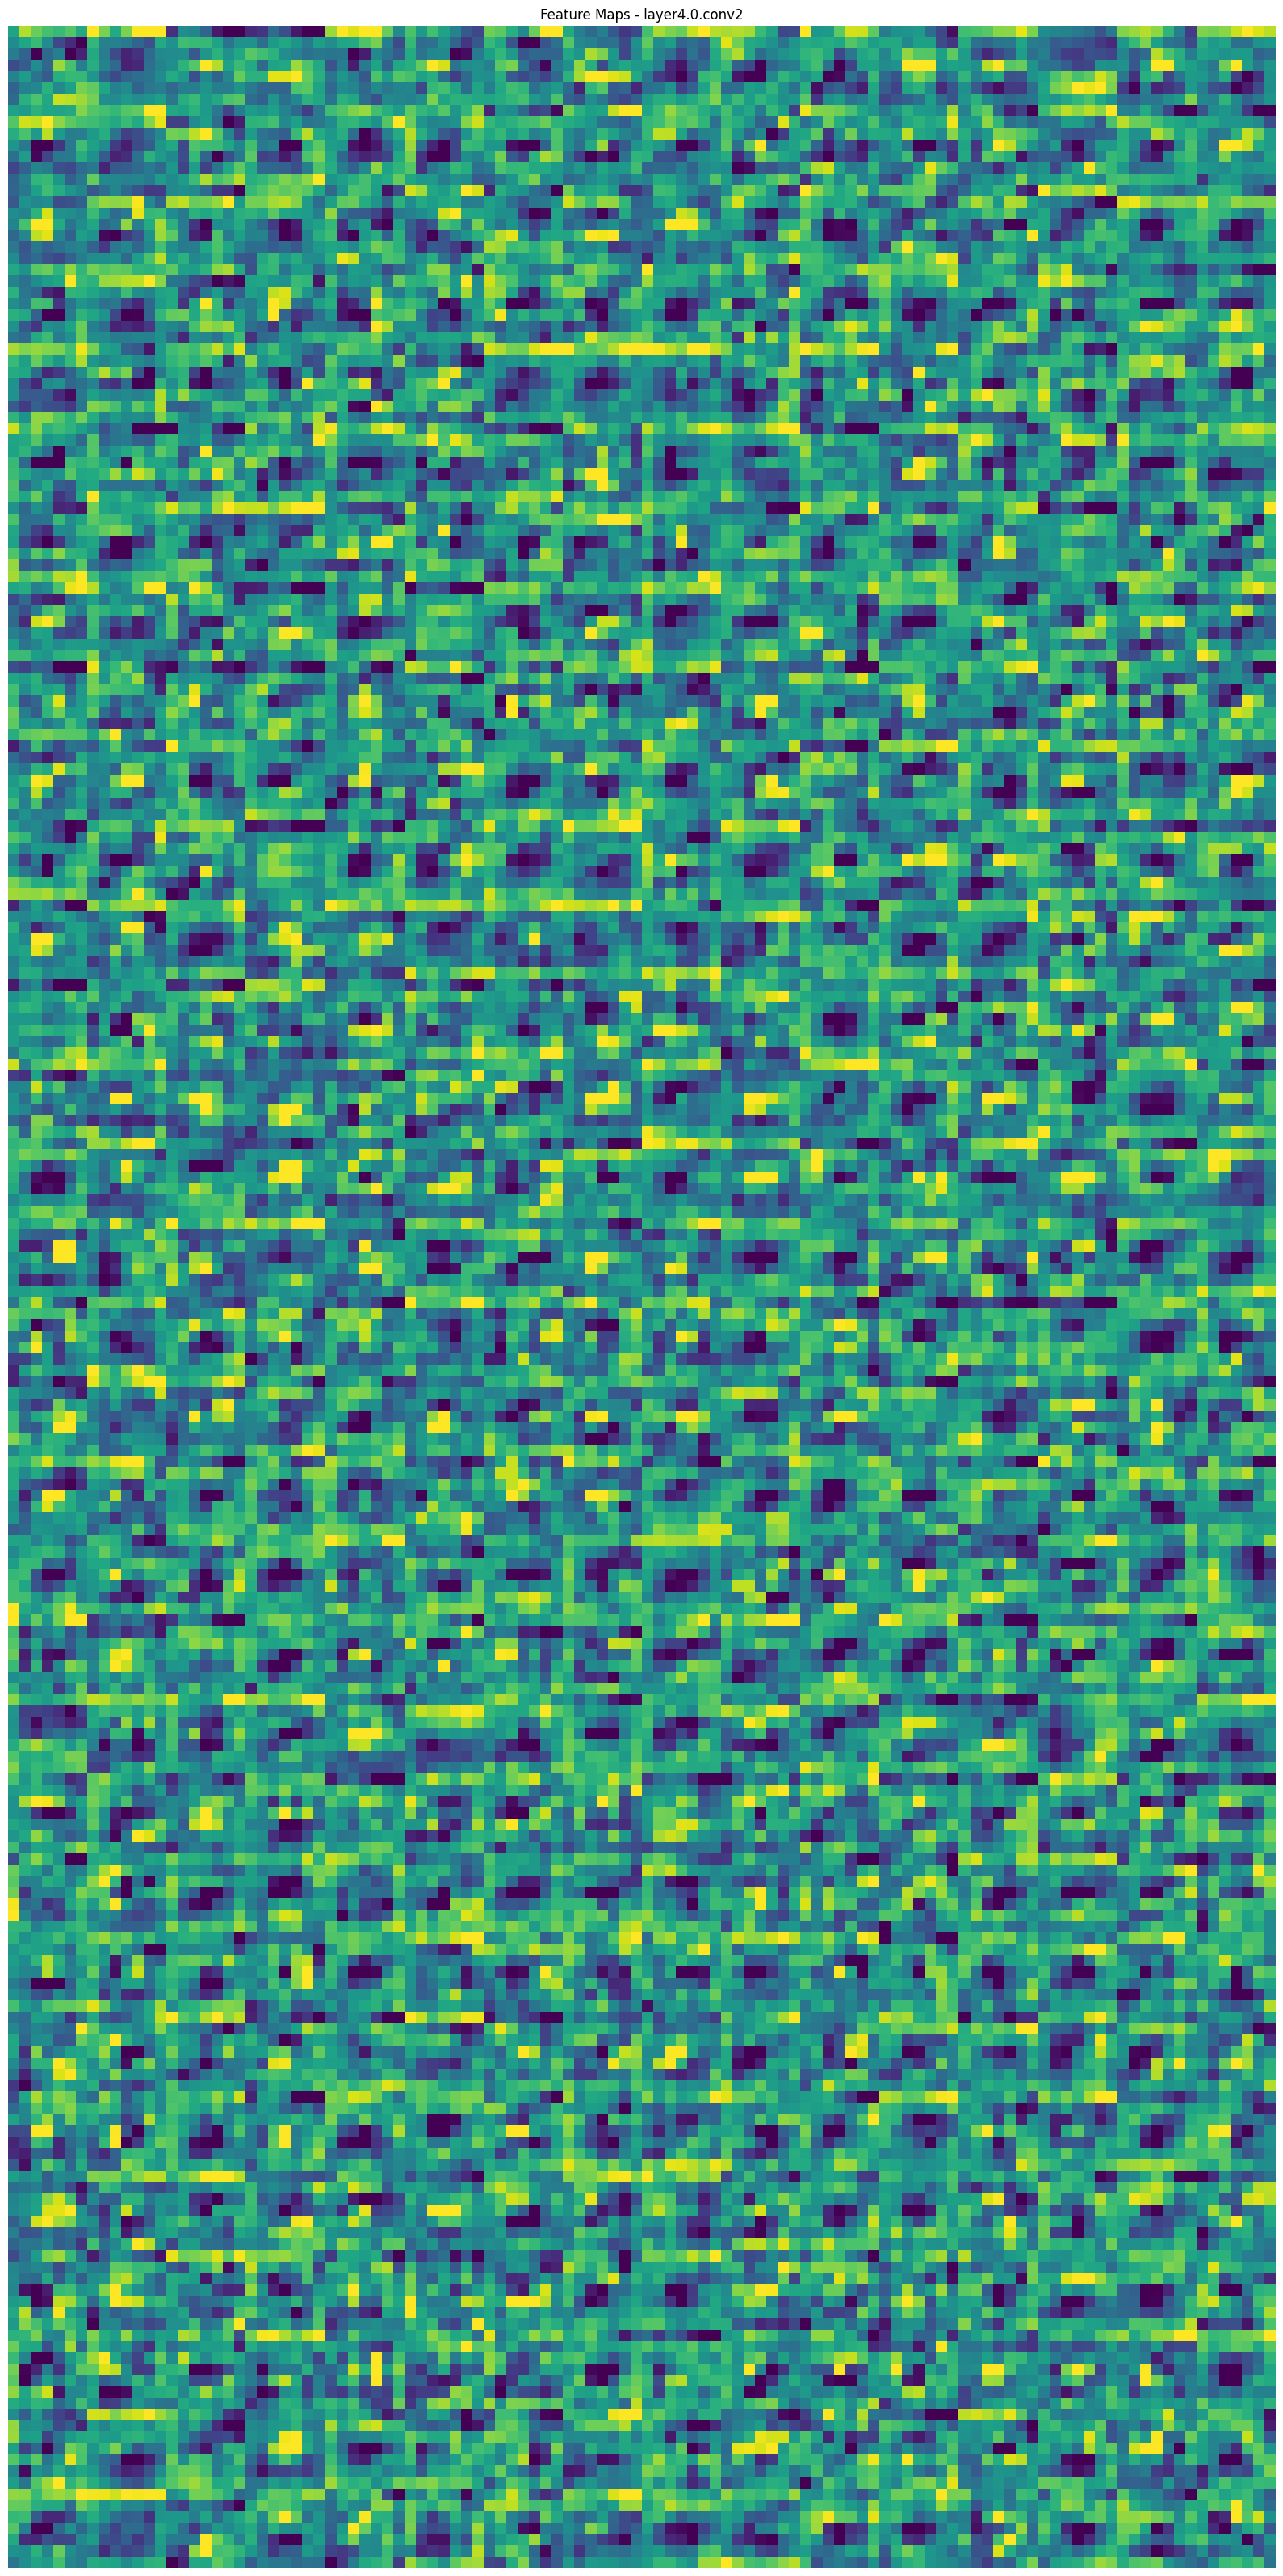

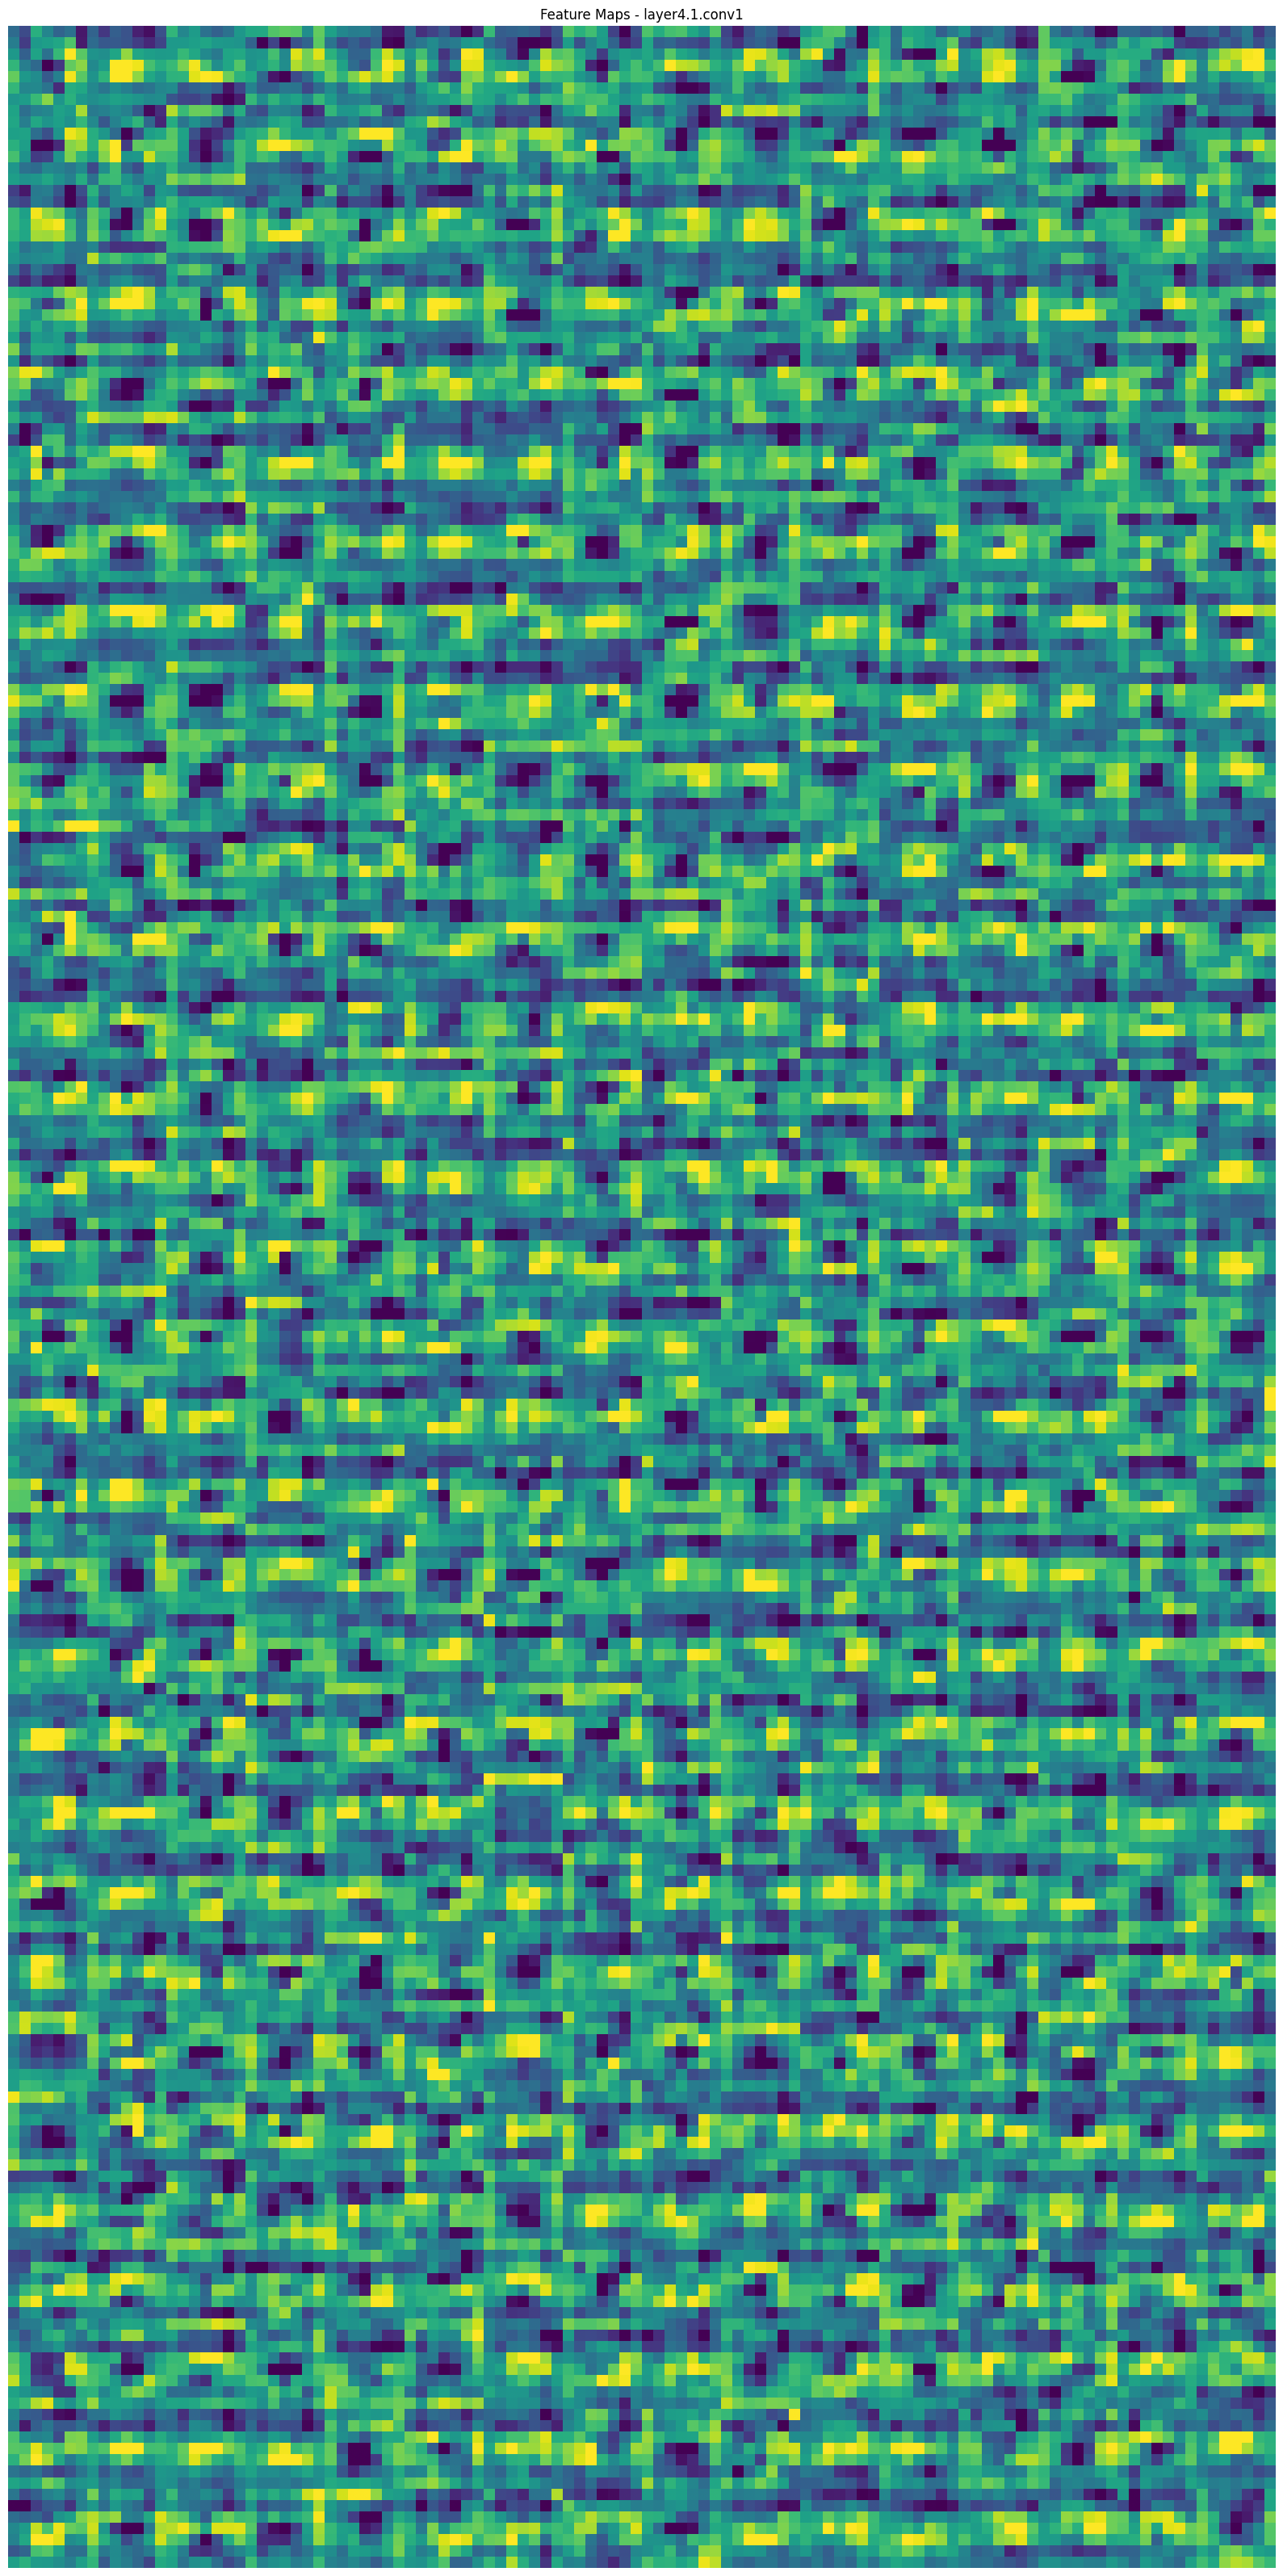

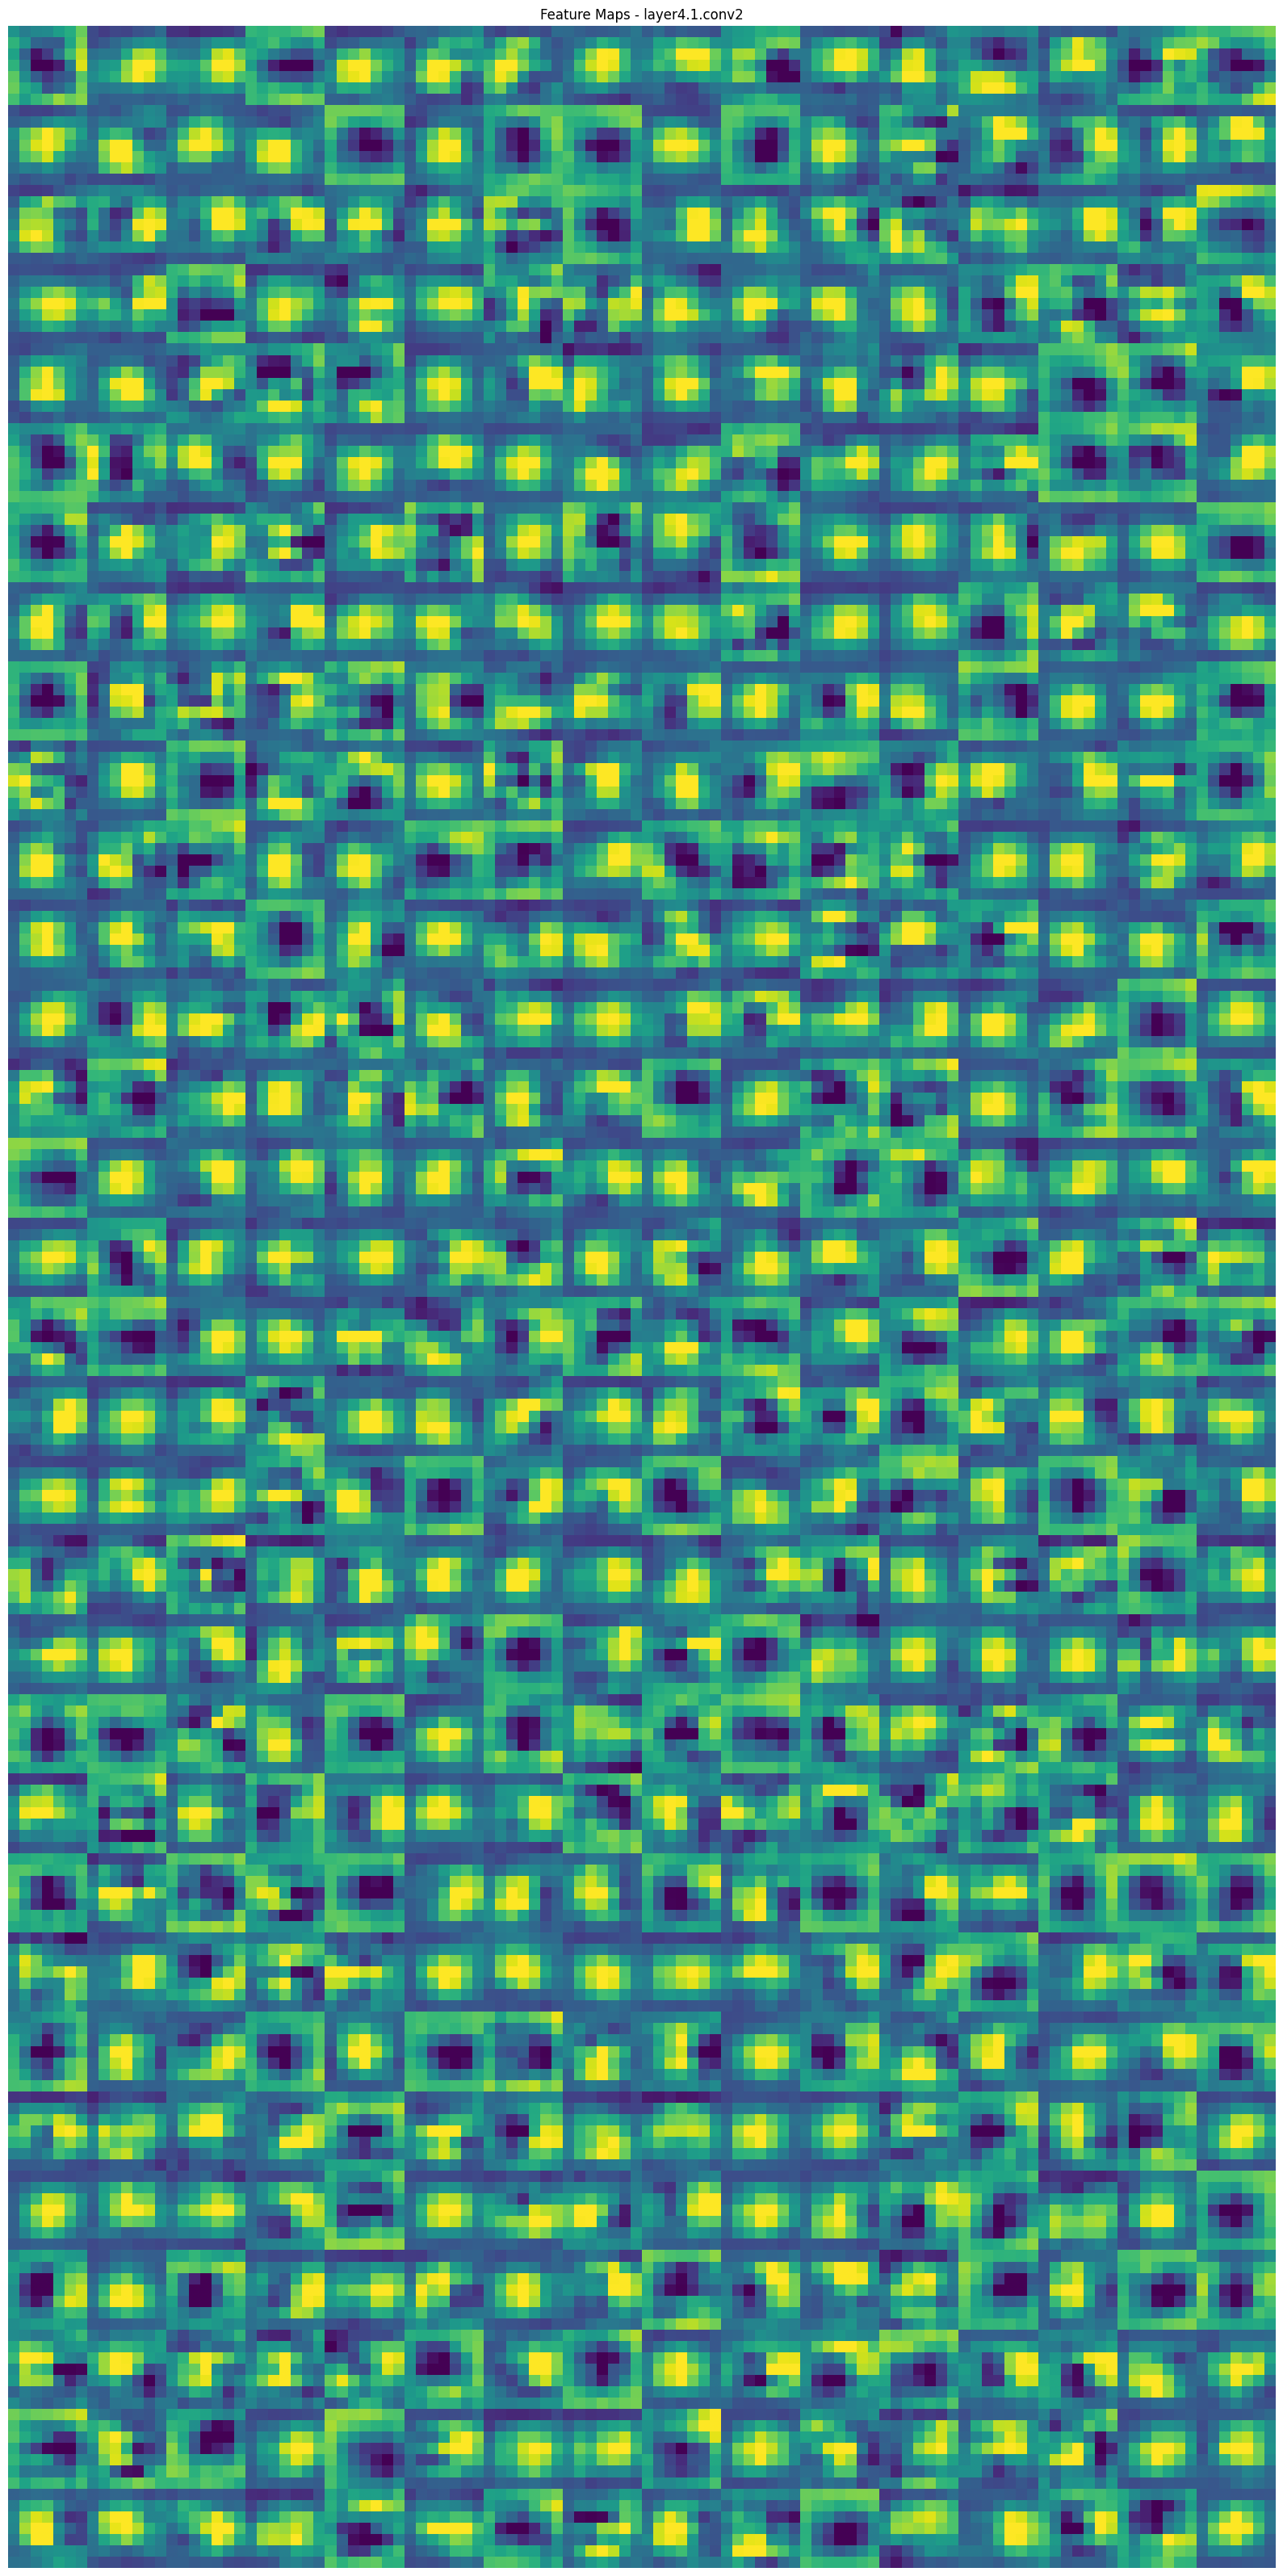

In [71]:
# - Take a sample image from the test dataset
data_index= 0 # take the first
image, target= dataset_test[data_index]
label= dataset_test.target2label[target]
image= image.unsqueeze(0)

print("image")
print(type(image))
print(image.shape)

# - Draw feature maps
weightfile= os.path.join(rundir, "resnet_model_weights.pth")

draw_feature_maps(
  classifier_resnet,
  image,
  weightfile=weightfile,
  images_per_row=16
)

#### Visualizing heatmaps of class activation
**Class Activation Maps (CAM)** help us understand which regions of an input image most influenced the model's classification decision. These maps highlight **spatial regions** in the image that are important for predicting a specific class.

A **class activation heatmap** is a 2D grid of scores—computed for each spatial location in the input—that indicates how important each region is with respect to the output class.

In this tutorial, we'll use the **Grad-CAM** technique (*Gradient-weighted Class Activation Mapping*), as described in:

> *“Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization”*

This method works by:

- Taking the output feature map from a convolutional layer (given an input image)  
- Computing the gradient of the class score with respect to each channel in the feature map  
- Using these gradients to **weight each channel**  
- Combining them to produce a spatial heatmap of class-relevant activations

> *Intuitively, this highlights "how intensely the image activates the class" across different regions.*

We will use an existing Python implementation of Grad-CAM for this visualization.

Let's plot the class activation heatmaps from the **last convolutional layer**, with respect to the **predicted class**, for a sample of test images.

In [ ]:
def plot_sample_predictions(
  classifier,
  dataset,
  dataset_gradcam=None,
  modelfile="",
  weightfile="",
  plot_gradcam=True,
  gradcam_method="gradcam",
  layer_names=[],
  aug_smooth=False,
  eigen_smooth=False,
  gradcam_alpha=0.5,
  apply_heatmap_thr=False,
  heatmap_thr=0.7,
  plot_gradcam_only=False
):
  """ Plot gradCAM on some images """

  # - Load model from file?
  if modelfile=="":
    model= classifier.model
  else:
    print(f"Loading model from: {modelfile}")
    model= torch.load(modelfile, weights_only=False)

  # - Check for model/dataloader
  if model is None:
    print("ERROR: No model present, cannot run prediction on test set!")
    return None

  # - Load model weights
  if weightfile!="":
    print(f"Loading weights from: {weightfile}")
    model.load_state_dict(torch.load(weightfile, weights_only=True))

  model= model.to(classifier.device).eval()

  # - Set dataset to be used for gradcam
  if dataset_gradcam is None:
    dataset_gradcam= dataset

  # - Map Grad-CAM methods
  methods = {
    "gradcam": GradCAM,
    "hirescam": HiResCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "eigengradcam": EigenGradCAM,
    "layercam": LayerCAM,
    "fullgrad": FullGrad,
    #"fem": FEM,
    "gradcamelementwise": GradCAMElementWise,
    "kpcacam": KPCA_CAM,
    #"shapleycam": ShapleyCAM
  }
  cam_algorithm = methods.get(gradcam_method.lower())
  if cam_algorithm is None:
    raise ValueError(f"Unsupported Grad-CAM method: {gradcam_method}")

  # - Retrieve target layers
  print("Finding target ReLU layers in model...")
  print(find_layer_types_recursive(model, [torch.nn.ReLU]))
  target_layers= []
  for name in layer_names:
    if hasattr(model, name):
      target_layers.append(getattr(model, name))
    elif name in model._modules:
      target_layers.append(model._modules[name])
    else:
      print(f"WARNING: Layer '{name}' not found in model.")

    #layer= model._modules[name]
    #print("layer")
    #print(layer)
    #target_layers.append(layer)

  if not target_layers:
    print("ERROR: No valid target layers provided for Grad-CAM.")
    return None

  print("--> target_layers")
  print(target_layers)

  # - Plot images
  fig = plt.figure(figsize=(15, 15))

  #for i, ((input_img, target), (input_img_gradcam, target_gradcam)) in islice(enumerate(zip(dataset,dataset_gradcam)), 16):
  for i, ((img, target), (img_gc, _)) in islice(enumerate(zip(dataset, dataset_gradcam)), 16):
    with torch.enable_grad():
      # - Compute model prediction
      label= dataset.target2label[target]
      print("--> Computing model prediction for image (label=%s, target=%d) ..." % (label, target))
      input_tensor= img.unsqueeze(0).to(classifier.device)
      input_tensor_gc= img_gc.unsqueeze(0).to(classifier.device)

      with torch.no_grad():
        logits = model(input_tensor)
        pred_idx = logits.argmax(dim=1).item()
        softmax_probs = torch.nn.functional.softmax(logits, dim=1)
        prob_pred = softmax_probs.max().item()
        label_pred = dataset.target2label[pred_idx]

      # - Convert input image to numpy
      rgb_img = img_gc.permute(1, 2, 0).cpu().numpy()
      grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

      # - Compute cam
      if plot_gradcam:
        with cam_algorithm(model=model, target_layers=target_layers) as cam:
          grayscale_cam = cam(
            #input_tensor=input_tensor_gc,
            input_tensor=input_tensor,
            #targets=None,
            targets=[ClassifierOutputTarget(pred_idx)],
            aug_smooth=aug_smooth,
            eigen_smooth=eigen_smooth
          )[0,:]
          cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=gradcam_alpha)
          cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

          # - Create thresholded heatmap
          heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
          heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
          alphas = np.ones(grayscale_img.shape) * gradcam_alpha
          if apply_heatmap_thr:
            alphas[grayscale_cam < heatmap_thr] = 0 # set invisible

      # - Plot image
      ax = fig.add_subplot(4, 4, i+1)
      ax.set_xticks([]); ax.set_yticks([])
      if not plot_gradcam_only:
        ax.imshow(grayscale_img, cmap="gray")

      if plot_gradcam:
        if plot_gradcam_only:
          ax.imshow(cam_image)
        else:
          ax.imshow(heatmap, alpha=alphas)

      ax.set_title(f'{label} \n pred: {label_pred}, p={prob_pred:.1f})', fontsize=11)

  plt.tight_layout()
  plt.show()

In [ ]:
# - Run gradCAM on some test data
target_layers= ["layer4"]
weightfile= os.path.join(rundir, "resnet_model_weights.pth")

plot_sample_predictions(
  classifier_resnet,
  dataset=dataset_test,
  dataset_gradcam=dataset_test_draw,
  weightfile=weightfile,
  plot_gradcam=True,
  layer_names=target_layers,
  gradcam_method="gradcam",
  aug_smooth=False,
  eigen_smooth=False,
  gradcam_alpha=0.3,
  apply_heatmap_thr=True,
  heatmap_thr=0.5
)

## Custom classifier
Let’s implement a custom classifier by creating a class that defines a configurable neural network architecture using PyTorch's `nn.Sequential`.
This will allow us to easily stack layers and experiment with different configurations for training and evaluation.

In [ ]:
class CustomClassifier():
  """Build a configurable custom CNN classifier using nn.Sequential."""

  def __init__(
    self,
    num_classes: int = 4,
    n_conv_layers: int = 3,
    n_filters: Union[int, List[int]] = [8, 16, 32],
    kern_sizes: Union[int, List[int]] = [3, 5, 7],
    strides: Union[int, List[int]] = [1, 1, 1],
    add_maxpool: bool = True,
    pool_sizes: Union[int, List[int]] = 2,
    add_batchnorm: bool = True,
    n_dense_layers: int = 1,
    dense_layer_sizes: Union[int, List[int]] = [64],
    add_dropout: bool = True,
    dropout_prob: float = 0.5,
  ):
    self.model= None
    self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.num_classes= num_classes
    self.n_conv_layers= n_conv_layers
    self.n_dense_layers= n_dense_layers
    self.add_maxpool= add_maxpool
    self.add_batchnorm= add_batchnorm
    self.add_dropout= add_dropout
    self.dropout_prob= dropout_prob

    # - Normalize all parameters to lists
    self.n_filters = self.__expand_param(n_filters, n_conv_layers, "n_filters")
    self.kern_sizes = self.__expand_param(kern_sizes, n_conv_layers, "kern_sizes")
    self.strides = self.__expand_param(strides, n_conv_layers, "strides")
    self.pool_sizes = self.__expand_param(pool_sizes, n_conv_layers, "pool_sizes")
    self.dense_layer_sizes = self.__expand_param(dense_layer_sizes, n_dense_layers, "dense_layer_sizes")

    # - Build network
    print("Building custom CNN architecture...")
    if self.__build_model()<0:
      raise RuntimeError("Failed to build neural network.")

    # - Move model to device
    print(f"Moving model to device: {self.device}")
    self.model.to(self.device)

  def __expand_param(self, param, expected_len, name):
    """Ensure param is a list of length expected_len."""
    if isinstance(param, list):
      if len(param) != expected_len:
        raise ValueError(f"Parameter '{name}' must have length equal to number of layers ({expected_len})")
      return param
    else:
      return [param] * expected_len

  def __build_model(self):
    """Create the CNN model using nn.Sequential."""

    self.model = torch.nn.Sequential()

    # - Add convolutional layers
    for i in range(self.n_conv_layers):
      # - Add convolution layer
      self.model.add_module(
        f"conv{i+1}",
        torch.nn.LazyConv2d(
          out_channels=self.n_filters[i],
          kernel_size=self.kern_sizes[i],
          stride=self.strides[i],
          padding="same"
        )
      )

      # - Add activation
      self.model.add_module(f"relu{i+1}", torch.nn.ReLU())

      # - Add BatchNorm
      if self.add_batchnorm:
        self.model.add_module(f"bn{i+1}", torch.nn.LazyBatchNorm2d())

      # - Add MaxPool
      if self.add_maxpool:
        self.model.add_module(f"pool{i+1}", torch.nn.MaxPool2d(kernel_size=self.pool_sizes[i]))

    # - Flatten layer
    self.model.add_module('flatten', torch.nn.Flatten())

    # - Fully connected layers
    for i in range(self.n_dense_layers):
      self.model.add_module(f"fc{i+1}", torch.nn.LazyLinear(self.dense_layer_sizes[i]))
      self.model.add_module(f"relu_fc{i+1}", torch.nn.ReLU())
      if self.add_dropout:
        self.model.add_module(f"dropout{i+1}", torch.nn.Dropout(p=self.dropout_prob))

    # - Optional dropout even if no dense layers
    if self.n_dense_layers==0 and self.add_dropout:
      self.model.add_module("dropout", torch.nn.Dropout(p=self.dropout_prob))

    # - Add output layer
    self.model.add_module("output", torch.nn.LazyLinear(self.num_classes))

    return 0

It's time to build your own custom CNN architecture!
You can experiment with different configurations - such as the number of convolutional layers, filter sizes, strides, and the fully connected head.

Below is an example that creates a custom classifier with 3 convolutional layers and a classification head with 1 dense hidden layer of 64 neurons:


```python
classifier= CustomClassifier(
  n_conv_layers= 3,
  n_filters= [8,16,32],
  kern_sizes= [3,5,7],
  strides= [1,1,1],
  add_maxpool= True,
  pool_sizes= 2,
  add_batchnorm= True,
  n_dense_layers= 1,
  dense_layer_sizes= [64],
  add_dropout= True,
  dropout_prob = 0.5
)
summary(classifier.model, input_shape)
```

Feel free to modify:

- Number of layers
- Filter sizes
- Add or remove max pooling or batch normalization
- Dropout settings
- Dense layer size

Use this as a starting point to explore and test different CNN architectures!

In [ ]:
##### ADD YOUR CODE HERE ######
# ...
# ...

### Train model
Train the custom classifier using the `CustomClassifier` class defined above, following the same steps used for the ResNet classifier.

You can reuse the previously defined components:

- The training method: `run_train()`
- The data loaders: `dataloader_train`, `dataloader_val`
- The plotting utilities: e.g., `draw_metric_hist`

> 💡 *Consider whether to apply ImageNet normalization as part of your input transform — this may or may not be beneficial for a custom model trained from scratch.*

Feel free to experiment with different model configurations and observe how they affect training performance.

In [ ]:
##### ADD YOUR CODE HERE ######
# ...
# ...

Let's plot the training and validation metrics after the training run is complete.

In [ ]:
##### ADD YOUR CODE HERE ######
# ...
# ...

### Evaluate model
Let's load the saved trained model and run inference on the test dataset.

You can reuse the previously defined methods:

- Evaluation: `run_test()`
- Plotting utilities:
  - `plot_sample_predictions()`
  - `draw_feature_maps()`

In [ ]:
##### ADD YOUR CODE HERE ######
# ...
# ...

#### Visualizing metrics

In [ ]:
##### ADD YOUR CODE HERE ######
# ...
# ...

#### Visualizing feature maps

In [ ]:
##### ADD YOUR CODE HERE ######
# ...
# ...

#### Visualizing heatmaps of class activation
Visualize heatmaps using ReLU layers by setting `target_layers` in `plot_sample_predictions` to one of the ReLU layer names.  
For example, if your model includes a layer named `"relu3"`, you can set:

```python
target_layers = ["relu3"]
```

In [ ]:
##### ADD YOUR CODE HERE ######
# ...
# ...